In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as smp
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import Image
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

In [2]:
init_vprinting()

https://www.youtube.com/watch?v=rJaXxb_piGI&t=111s

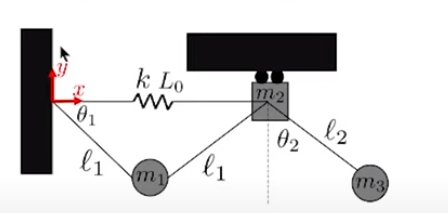

In [3]:
Image('/home/robotic/brown/code/python/Euler-Lagrange_Try/MechanicExam.jpeg')

In [4]:
#Define all symbols we need for this problem using sympy:
t, g, l1, l2, m1, m2, m3, k, L0 = smp.symbols('t g l_1 l_2 m_1 m_2 m_3 k L_0')
the1, the2 = smp.symbols(r'\theta_1 \theta_2', cls=smp.Function)
#the1, the2 = smp.symbols('theta_1 theta_2')

Define $\theta(t)$ and $\dot{\theta}(t)$ and $\ddot{\theta}(t)$

In [40]:
the1 = the1(t)
the2 = the2(t)
the1_d = smp.diff(the1, t)
the2_d = smp.diff(the2, t)
the1_dd = smp.diff(the1_d, t)
the2_dd = smp.diff(the2_d, t)

In [41]:
the1, the2, the1_d, the2_d, the1_dd, the2_dd  

Generalized coordinates:

In [46]:
q = smp.Array([the1,the2])
dq = q.diff(t)

[\thėta₁  \thėta₂]

Define the $x$ and $y$ coordinates of all three masses

In [51]:
x1 = l1*smp.cos(q[0])
y1 = -l1*smp.sin(q[0])
x2 = 2*x1
y2 = 0
x3 = x2 + l2*smp.sin(q[1])
y3 = -l2*smp.cos(q[1])


In [52]:
x1,y1,x2,y2,x3,y3

Define both kinetic and potential energy:

* Kinetic energy $T$ comes from the motion of the three masses
* Potential energy $V$ comes from both the gravitational potential energy of the masses $mgy$ and the potential energy in the spring $\frac{1}{2}kx^2$ where $x=x_2 - L_0$

In [74]:
T = smp.Rational(1,2) * m1 * (smp.diff(x1,t)**2 + smp.diff(y1,t)**2) \
    +smp.Rational(1,2) * m2 * (smp.diff(x2,t)**2 + smp.diff(y2,t)**2) \
    +smp.Rational(1,2) * m3 * (smp.diff(x3,t)**2 + smp.diff(y3,t)**2)

V = m1*g*y1 + m2*g*y2 + m3*g*y3 +smp.Rational(1,2) * k * (x2-L0)**2
L =T-V

In [75]:
L

Get Lagrange's equations

$$\frac{\partial L}{\partial \theta_1} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}} = 0$$
$$\frac{\partial L}{\partial \theta_2} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}} = 0$$

In [76]:
LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t).simplify()
LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t).simplify()

Solve Lagranges equations (this assumes that `LE1` and `LE2` are both equal to zero)

* We solve these equations (which are **linear** in $\ddot{\theta_1}$ and $\ddot{\theta_2}$) for $\ddot{\theta_1}$ and $\ddot{\theta_2}$.

In [20]:
sols = smp.solve([LE1, LE2], (the1_dd, the2_dd),
                simplify=False, rational=False)

Now we have 

* $\frac{d^2 \theta_1}{dt^2} = ...$
* $\frac{d^2 \theta_2}{dt^2} = ...$

These are two second order ODEs! In python we can only solve systems of first order ODEs. Any system of second order ODEs can be converted as follows:

1. Define $z_1 = d\theta_1/dt$ and $z_2=d\theta_2/dt$
2. Then $dz_1/dt = d^2\theta_1/dt^2$ and $dz_2/dt = d^2\theta_2/dt^2$

Now we get a system of 4 first order ODEs (as opposed to 2 second order ones)

* $d z_1/dt = ...$
* $d\theta_1/dt = z_1$
* $d z_2/dt = ...$
* $d\theta_2/dt = z_1$

We need to convert the **symbolic** expressions above to numerical functions so we can use them in a numerical python solver. For this we use `smp.lambdify`

In [21]:
dz1dt_f = smp.lambdify((t,g,k,L0,m1,m2,m3,l1,l2,the1,the2,the1_d,the2_d), sols[the1_dd])
dz2dt_f = smp.lambdify((t,g,k,L0,m1,m2,m3,l1,l2,the1,the2,the1_d,the2_d), sols[the2_dd])
dthe1dt_f = smp.lambdify(the1_d, the1_d)
dthe2dt_f = smp.lambdify(the2_d, the2_d)

Now define $\vec{S} = (\theta_1, z_1, \theta_2, z_2)$. IF we're going to use an ODE solver in python, we need to write a function that takes in $\vec{S}$ and $t$ and returns $d\vec{S}/dt$. In other words, we need to define $d\vec{S}/dt (\vec{S}, t)$

* Our system of ODEs can be fully specified using $d\vec{S}/dt$ and depends only on $\vec{S}$ and $t$

In [22]:
def dSdt(S, t, g, k, L0, m1, m2, m3, l1, l2):
    the1, z1, the2, z2 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(t,g,k,L0,m1,m2,m3,l1,l2,the1,the2,z1,z2),
        dthe2dt_f(z2),
        dz2dt_f(t,g,k,L0,m1,m2,m3,l1,l2,the1,the2,z1,z2),
    ]

Solve the system of ODEs using scipys `odeint` method

In [23]:
t = np.linspace(0, 40, 1001) # s
g = 9.81 #m/s^2
k = 30 # N/m
m1=2 # kg
m2=2 # kg
m3=1 # kg
l1 = 1 # m
l2 = 1 # m
L0 = 1.5*l1 # m
ans = odeint(dSdt, y0=[1, -1, -1, 1], t=t, args=(g, k, L0, m1, m2, m3, l1, l2))

25 times per second (number of data points). This will be important for animating later on.

Can obtain $\theta_1(t)$ and $\theta_2(t)$ from the answer

In [24]:
the1 = ans.T[0]
the2 = ans.T[2]

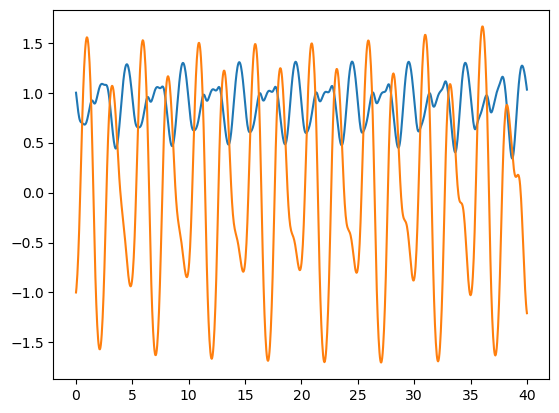

In [25]:
plt.plot(t, the1)
plt.plot(t, the2)

In [26]:
def get_x1y1x2y2x3y3(t, the1, the2, l1, l2):
    return (l1*np.cos(the1),
            -l1*np.sin(the1),
            2*l1*np.cos(the1),
            np.zeros(len(the1)),
            2*l1*np.cos(the1) + l2*np.sin(the2),
            -l2*np.cos(the2))

x1, y1, x2, y2, x3, y3 = get_x1y1x2y2x3y3(t, ans.T[0], ans.T[2], l1, l2)

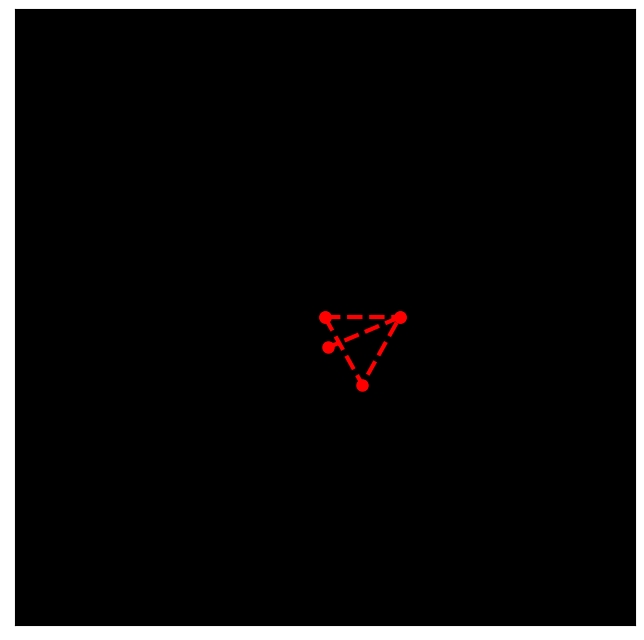

In [29]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i], x3[i]], [0, y1[i], y2[i], y3[i]])
    ln2.set_data([0, x2[i]], [0, y2[i]])
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ln2, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=25)

ALTERNATIVES CHECKING

In [ ]:
#Define the pose(position and orientation) of the center of mass of each link
P1 = smp.Matrix([x1,y1,q[0]])
P2 = smp.Matrix([x2,y2,0])
P3 = smp.Matrix([x3,y3,q[1]])
#P1,P2,P3

In [ ]:
#Jacobian of the link's CoM
J1 = P1.jacobian(q)
J2 = P2.jacobian(q)
J3 = P3.jacobian(q)
J1

In [ ]:
#Inertia matrices
G1 = np.diag(np.array([m1, m1, 0]))
G2 = np.diag(np.array([m2, m2, 0]))
G3 = np.diag(np.array([m3, m3, 0]))

In [ ]:
#Inertia matrices
M = J1.transpose() * G1 * J1 + J2.transpose() * G2 * J2 + J3.transpose() * G3 * J3
M

In [ ]:
# VV also represents the potential energy
VV = g * (m1 * P1[1] + m2 * P2[1] + m3 * P3[1])

In [ ]:
#Gravity vector
G = VV.diff(q)